In [4]:
import numpy as np
import cv2
from tifffile import imread, imwrite
from pathlib import Path
import logging
from satellite_image_padder import SatelliteImagePadder, logger
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.transform import Affine

PADATA_DIR = Path("pdata") 
TARGET_SIZE = (256, 256)
PADDING_MODE = "zero"  
ALIGNMENT = "center"         # –í—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ (top_left, bottom_right, center)
logger.setLevel(logging.WARNING)

padder = SatelliteImagePadder(default_target_size=TARGET_SIZE)

def process_file(file_path, output_dir, padder, mode, alignment):
    try:
        image = imread(file_path)
        image = np.transpose(image, (2, 0, 1))

        padded_image, padding_mask = padder.pad(image, mode=mode, alignment=alignment)

        out_path = output_dir / file_path.name
        C, H, W = padded_image.shape
        
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=H,
            width=W,
            count=C,
            dtype=str(padded_image.dtype),
            crs=None,
            transform=Affine.identity()
        ) as dst:
            for i in range(C):
                dst.write(padded_image[i, :, :], i + 1)

        mask_out_path = output_dir / f"{file_path.stem}_padmask.tiff"
        with rasterio.open(
            mask_out_path,
            'w',
            driver='GTiff',
            height=H,
            width=W,
            count=1,
            dtype='uint8',
            crs=None,
            transform=Affine.identity()
        ) as dst:
            dst.write(padding_mask, 1)

    except Exception as e:
        logger.error(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –æ–±—Ä–∞–±–æ—Ç–∫–µ —Ñ–∞–π–ª–∞ {file_path}: {e}")

def process_images(input_dir, output_dir, padder, mode, alignment):
    if not input_dir.exists():
        logger.warning(f"–î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è {input_dir} –Ω–µ –Ω–∞–π–¥–µ–Ω–∞, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º.")
        return

    output_dir.mkdir(exist_ok=True)
    files = list(input_dir.glob("*.tiff"))

    with ThreadPoolExecutor() as executor:
        executor.map(
            lambda f: process_file(f, output_dir, padder, mode, alignment),
            files
        )

for field_dir in PADATA_DIR.iterdir():
    if not field_dir.is_dir():
        continue

    for date_dir in field_dir.iterdir():
        if not date_dir.is_dir():
            continue

        logger.info(f"–û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º: {date_dir}")

        optical_input_dir = date_dir / "raw_imgs_optical"
        optical_output_dir = date_dir / f"padded_optical_{PADDING_MODE}"
        process_images(optical_input_dir, optical_output_dir, padder, PADDING_MODE, ALIGNMENT)

        sar_input_dir = date_dir / "raw_imgs_sar"
        sar_output_dir = date_dir / f"padded_sar_{PADDING_MODE}"
        process_images(sar_input_dir, sar_output_dir, padder, PADDING_MODE, ALIGNMENT)

print("–ì–æ—Ç–æ–≤–æ! –í—Å–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø–∞–¥–¥–∏–Ω–≥–æ–≤—ã–µ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã.")

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


–ì–æ—Ç–æ–≤–æ! –í—Å–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø–∞–¥–¥–∏–Ω–≥–æ–≤—ã–µ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã.


In [4]:
import numpy as np
import rasterio
from pathlib import Path

def print_image_info(image_path: Path):
    """
    –í—ã–≤–æ–¥–∏—Ç –ø–æ–¥—Ä–æ–±–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ TIFF-–∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏.
    –í–∫–ª—é—á–∞–µ—Ç –º–µ—Ç–∞–¥–∞–Ω–Ω—ã–µ –∏ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –∫–∞–∂–¥–æ–º—É –∫–∞–Ω–∞–ª—É.
    """
    print(f"–§–∞–π–ª: {image_path}")
    try:
        with rasterio.open(image_path) as src:
            data = src.read()  # shape = (bands, height, width)
            print(f"  –î—Ä–∞–π–≤–µ—Ä: {src.driver}")
            print(f"  CRS: {src.crs}")
            print(f"  Transform: {src.transform}")
            print(f"  –†–∞–∑–º–µ—Ä: {src.width} x {src.height}")
            print(f"  –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞–Ω–∞–ª–æ–≤: {src.count}")
            print(f"  –¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {data.dtype}")
            for band in range(src.count):
                band_data = data[band]
                band_min = np.nanmin(band_data)
                band_max = np.nanmax(band_data)
                band_mean = np.nanmean(band_data)
                band_std = np.nanstd(band_data)
                print(f"  –ö–∞–Ω–∞–ª {band+1}: min={band_min}, max={band_max}, mean={band_mean:.3f}, std={band_std:.3f}")
            print("-" * 60)
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ —á—Ç–µ–Ω–∏–∏ {image_path}: {e}")

def print_transformed_info(image_path: Path, epsilon=1e-8):
    """
    –ü—Ä–∏–º–µ–Ω—è–µ—Ç –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ 10 * log10(data + epsilon) –∏ –≤—ã–≤–æ–¥–∏—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞–Ω–∞–ª–∞.
    –≠—Ç–æ –ø–æ–ª–µ–∑–Ω–æ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ SAR-—Å–Ω–∏–º–∫–æ–≤, –µ—Å–ª–∏ –æ–Ω–∏ –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å –≤ –¥–µ—Ü–∏–±–µ–ª–∞—Ö.
    """
    #print(f"–ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–Ω–æ–µ (dB) –¥–ª—è —Ñ–∞–π–ª–∞: {image_path}")
    try:
        with rasterio.open(image_path) as src:
            data = src.read().astype(np.float32)
            # –ü—Ä–∏–º–µ–Ω—è–µ–º –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ: 10*log10(data + epsilon)
            data_db = 10 * np.log10(data)
            for band in range(src.count):
                band_data = data_db[band]
                band_min = np.nanmin(band_data)
                band_max = np.nanmax(band_data)
                band_mean = np.nanmean(band_data)
                band_std = np.nanstd(band_data)
                print(f"  –ö–∞–Ω–∞–ª {band+1} (dB): min={band_min:.3f}, max={band_max:.3f}, mean={band_mean:.3f}, std={band_std:.3f}")
            print("-" * 60)
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–∏ {image_path}: {e}")

def scan_directory(directory: Path, transform=False, limit=50):
    """
    –†–µ–∫—É—Ä—Å–∏–≤–Ω–æ —Å–∫–∞–Ω–∏—Ä—É–µ—Ç –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é –∏ –≤—ã–≤–æ–¥–∏—Ç –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –¥–ª—è –ø–µ—Ä–≤—ã—Ö limit TIFF-—Ñ–∞–π–ª–æ–≤.
    –ï—Å–ª–∏ transform=True, –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –≤—ã–≤–æ–¥–∏—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ—Å–ª–µ –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–≥–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è.
    """
    tiff_files = list(directory.rglob("*.tif*"))
    limited_files = tiff_files[:limit]
    print(f"–ù–∞–π–¥–µ–Ω–æ {len(tiff_files)} TIFF —Ñ–∞–π–ª–æ–≤ –≤ {directory}. –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö {len(limited_files)} —Ñ–∞–π–ª–æ–≤.\n")
    for file in limited_files:
        print_image_info(file)
        if transform:
            print_transformed_info(file)

if __name__ == "__main__":
    raw_images_dir = Path("clouds/s1")
    scan_directory(raw_images_dir, transform=True, limit=20)

–ù–∞–π–¥–µ–Ω–æ 122218 TIFF —Ñ–∞–π–ª–æ–≤ –≤ clouds/s1. –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö 20 —Ñ–∞–π–ª–æ–≤.

–§–∞–π–ª: clouds/s1/ROIs1158_spring_1_p306.tif
  –î—Ä–∞–π–≤–µ—Ä: GTiff
  CRS: EPSG:32737
  Transform: | 10.00, 0.00, 394612.34|
| 0.00,-10.00, 8105222.84|
| 0.00, 0.00, 1.00|
  –†–∞–∑–º–µ—Ä: 256 x 256
  –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞–Ω–∞–ª–æ–≤: 2
  –¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: float32
  –ö–∞–Ω–∞–ª 1: min=-19.630796432495117, max=-0.9753064513206482, mean=-10.894, std=1.956
  –ö–∞–Ω–∞–ª 2: min=-27.337907791137695, max=-9.513772964477539, mean=-16.811, std=2.125
------------------------------------------------------------
  –ö–∞–Ω–∞–ª 1 (dB): min=nan, max=nan, mean=nan, std=nan
  –ö–∞–Ω–∞–ª 2 (dB): min=nan, max=nan, mean=nan, std=nan
------------------------------------------------------------
–§–∞–π–ª: clouds/s1/ROIs1158_spring_1_p504.tif
  –î—Ä–∞–π–≤–µ—Ä: GTiff
  CRS: EPSG:32737
  Transform: | 10.00, 0.00, 388212.34|
| 0.00,-10.00, 8096262.84|
| 0.00, 0.00, 1.00|
  –†–∞–∑–º–µ—

/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: invalid value encountered in log10
  data_db = 10 * np.log10(data)
/tmp/ipykernel_528749/2225551689.py:44: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band_data)
/tmp/ipykernel_528749/2225551689.py:45: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band_data)
/tmp/ipykernel_528749/2225551689.py:46: RuntimeWarning: Mean of empty slice
  band_mean = np.nanmean(band_data)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: divide by zero encountered in log10
  data_db = 10 * np.log10(data)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


In [5]:
if __name__ == "__main__":
    raw_images_dir = Path("clouds/s2_cloudy")
    scan_directory(raw_images_dir, transform=True, limit=20)

–ù–∞–π–¥–µ–Ω–æ 122218 TIFF —Ñ–∞–π–ª–æ–≤ –≤ clouds/s2_cloudy. –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö 20 —Ñ–∞–π–ª–æ–≤.

–§–∞–π–ª: clouds/s2_cloudy/ROIs1158_spring_15_p258.tif
  –î—Ä–∞–π–≤–µ—Ä: GTiff
  CRS: EPSG:32756
  Transform: | 10.00, 0.00, 332700.44|
| 0.00,-10.00, 7289866.58|
| 0.00, 0.00, 1.00|
  –†–∞–∑–º–µ—Ä: 256 x 256
  –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞–Ω–∞–ª–æ–≤: 13
  –¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: uint16
  –ö–∞–Ω–∞–ª 1: min=1279, max=6370, mean=1991.737, std=1101.852
  –ö–∞–Ω–∞–ª 2: min=865, max=6909, mean=1741.937, std=1232.668
  –ö–∞–Ω–∞–ª 3: min=564, max=6824, mean=1599.663, std=1241.377
  –ö–∞–Ω–∞–ª 4: min=354, max=7380, mean=1489.604, std=1409.115
  –ö–∞–Ω–∞–ª 5: min=401, max=7304, mean=1757.860, std=1344.724
  –ö–∞–Ω–∞–ª 6: min=504, max=7862, mean=2660.906, std=1305.462
  –ö–∞–Ω–∞–ª 7: min=566, max=8285, mean=3047.840, std=1344.828
  –ö–∞–Ω–∞–ª 8: min=419, max=8001, mean=2909.459, std=1280.262
  –ö–∞–Ω–∞–ª 9: min=514, max=8672, mean=3374.206, std=1379.084
  –ö–∞–Ω–∞–ª 10: min

In [6]:
if __name__ == "__main__":
    raw_images_dir = Path("pdata/0127/0127 2024-01-01/raw_imgs_sar")
    scan_directory(raw_images_dir, transform=True, limit=20)

–ù–∞–π–¥–µ–Ω–æ 114 TIFF —Ñ–∞–π–ª–æ–≤ –≤ pdata/0127/0127 2024-01-01/raw_imgs_sar. –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö 20 —Ñ–∞–π–ª–æ–≤.

–§–∞–π–ª: pdata/0127/0127 2024-01-01/raw_imgs_sar/SAR_pair_0_20231122_0309.tiff
  –î—Ä–∞–π–≤–µ—Ä: GTiff
  CRS: EPSG:4326
  Transform: | 10.00, 0.00, 0.00|
| 0.00,-10.00, 0.00|
| 0.00, 0.00, 1.00|
  –†–∞–∑–º–µ—Ä: 78 x 134
  –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–∞–Ω–∞–ª–æ–≤: 2
  –¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: float32
  –ö–∞–Ω–∞–ª 1: min=-60.0, max=5.86023473739624, mean=-11.291, std=4.452
  –ö–∞–Ω–∞–ª 2: min=-60.0, max=-6.252169609069824, mean=-20.813, std=9.104
------------------------------------------------------------
  –ö–∞–Ω–∞–ª 1 (dB): min=-17.224, max=7.679, mean=0.065, std=4.694
  –ö–∞–Ω–∞–ª 2 (dB): min=nan, max=nan, mean=nan, std=nan
------------------------------------------------------------
–§–∞–π–ª: pdata/0127/0127 2024-01-01/raw_imgs_sar/SAR_pair_1_20230923_0309.tiff
  –î—Ä–∞–π–≤–µ—Ä: GTiff
  CRS: EPSG:4326
  Transform: | 10.00, 0.00, 0.00|
| 0.00,

/tmp/ipykernel_528749/2225551689.py:41: RuntimeWarning: invalid value encountered in log10
  data_db = 10 * np.log10(data)
/tmp/ipykernel_528749/2225551689.py:44: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band_data)
/tmp/ipykernel_528749/2225551689.py:45: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band_data)
/tmp/ipykernel_528749/2225551689.py:46: RuntimeWarning: Mean of empty slice
  band_mean = np.nanmean(band_data)


In [12]:
if __name__ == "__main__":
    raw_images_dir = Path("pdata/0127/0127 2024-01-01/padded_imgs_sar")
    scan_directory(raw_images_dir, transform=True, limit=20)

–ù–∞–π–¥–µ–Ω–æ 0 TIFF —Ñ–∞–π–ª–æ–≤ –≤ pdata/0127/0127 2024-01-01/padded_imgs_sar. –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö 0 —Ñ–∞–π–ª–æ–≤.



In [21]:
import os
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import rasterio
import re
from datetime import datetime, timedelta
import shutil

def get_rescaled_data(data, limits):
    """
    –õ–∏–Ω–µ–π–Ω–æ –º–∞—Å—à—Ç–∞–±–∏—Ä—É–µ–º –∑–Ω–∞—á–µ–Ω–∏–µ data –≤ –¥–∏–∞–ø–∞–∑–æ–Ω [0..1] –Ω–∞ –æ—Å–Ω–æ–≤–µ –∑–∞–¥–∞–Ω–Ω—ã—Ö limits=[min, max].
    –í—Å–µ, —á—Ç–æ –º–µ–Ω—å—à–µ min, –ø—Ä–∏–∂–º–µ—Ç—Å—è –∫ 0, —á—Ç–æ –±–æ–ª—å—à–µ max ‚Äî –∫ 1.
    """
    out = (data - limits[0]) / (limits[1] - limits[0])
    out = np.clip(out, 0.0, 1.0)
    return out

def get_normalized_difference(channel1, channel2):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç (channel1 - channel2)/(channel1 + channel2).
    –ï—Å–ª–∏ (channel1 + channel2)==0, —Ç–æ –¥–µ–ª–∏—Ç–µ–ª—å –∑–∞–º–µ–Ω–∏–º –Ω–∞ –º–∞–ª–µ–Ω—å–∫—É—é –∫–æ–Ω—Å—Ç–∞–Ω—Ç—É.
    """
    sub_ = channel1 - channel2
    sum_ = channel1 + channel2
    sum_[sum_ == 0] = 1e-6
    return sub_ / sum_

def get_shadow_mask(data_image):
    """
    –ü—Ä–∏–º–µ—Ä –ø—Ä–æ—Å—Ç–µ–π—à–µ–π –æ—Ü–µ–Ω–∫–∏ —Ç–µ–Ω–µ–π (shadow). –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç 2D-–º–∞—Å—Å–∏–≤, –≥–¥–µ -1=—Ç–µ–Ω—å, 0=–Ω–µ—Ç —Ç–µ–Ω–∏.
    –û—Ä–∏–µ–Ω—Ç–∏—Ä—É–µ–º—Å—è –Ω–∞ Blue (B2), NIR (B8) –∏ SWIR1 (B12 –¥–ª—è Sentinel2, –Ω–æ –∑–¥–µ—Å—å index=11).
    """
    data_image = data_image / 10000.0
    ch, r, c = data_image.shape
    shadow_mask = np.zeros((r, c), dtype='float32')

    # Blue = data_image[1], NIR=data_image[7], SWIR1=data_image[11] (Sentinel-2)
    BB = data_image[1]
    BNIR = data_image[7]
    BSWIR1 = data_image[11]

    # CSI = —Å—Ä–µ–¥–Ω–µ–µ (NIR+SWIR1)/2
    CSI = (BNIR + BSWIR1) / 2.0
    # –ü–æ—Ä–æ–≥ T3
    t3 = 3/4
    T3 = np.min(CSI) + t3 * (np.mean(CSI) - np.min(CSI))

    # –ü–æ—Ä–æ–≥ T4
    t4 = 5/6
    T4 = np.min(BB) + t4 * (np.mean(BB) - np.min(BB))

    # –£—Å–ª–æ–≤–∏–µ —Ç–µ–Ω–∏
    shadow_tf = np.logical_and(CSI < T3, BB < T4)
    shadow_mask[shadow_tf] = -1

    return shadow_mask

def get_cloud_mask(data_image, cloud_threshold=0.2, binarize=True):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç 2D-–∫–∞—Ä—Ç—É "score" –∏–ª–∏ –±–∏–Ω–∞—Ä–Ω—É—é –∫–∞—Ä—Ç—É (1=–æ–±–ª–∞–∫–æ, 0=–Ω–µ–±–æ).
    data_image –æ–∂–∏–¥–∞–µ—Ç—Å—è –≤ –∫–∞–ª–∏–±—Ä–æ–≤–∫–µ [0..10000] –¥–æ –¥–µ–ª–µ–Ω–∏—è.
    """
    data_norm = data_image / 10000.0
    ch, r, c = data_norm.shape
    score = np.ones((r, c), dtype='float32')

    # 1) –û–≥—Ä–∞–Ω–∏—á–∏–º BLUE –≤ [0.1..0.5]
    score = np.minimum(score, get_rescaled_data(data_norm[1], [0.1, 0.5]))
    # 2) –û–≥—Ä–∞–Ω–∏—á–∏–º COASTAL –≤ [0.1..0.3] - —É—Å–ª–æ–≤–Ω–æ data_norm[0]
    score = np.minimum(score, get_rescaled_data(data_norm[0], [0.1, 0.3]))
    # 3) sum of Red+Green+Blue
    RGB_sum = data_norm[3] + data_norm[2] + data_norm[1]
    score = np.minimum(score, get_rescaled_data(RGB_sum, [0.2, 0.8]))

    # 4) NDSI = (Green - SWIR1)/(Green + SWIR1)
    ndsi = get_normalized_difference(data_norm[2], data_norm[11])
    score = np.minimum(score, get_rescaled_data(ndsi, [0.8, 0.6]))  # –∏–Ω–≤–µ—Ä—Å–∏—è –ø–æ—Ä–æ–≥–∞

    if binarize:
        # –ë–∏–Ω–∞—Ä–∏–∑—É–µ–º –ø–æ cloud_threshold
        cloud_bin = np.zeros_like(score, dtype='uint8')
        cloud_bin[score >= cloud_threshold] = 0
        cloud_bin[score < cloud_threshold] = 1
        return cloud_bin
    else:
        # –í–æ–∑–≤—Ä–∞—â–∞–µ–º –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—É—é –∫–∞—Ä—Ç—É score
        return score

def get_cloud_cloudshadow_mask(data_image, cloud_threshold=0.2):
    """
    –°–æ–≤–º–µ—â–∞–µ–º –æ–±–ª–∞–∫–∞ –∏ —Ç–µ–Ω–∏.
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç 2D np.array —Å:
     1 = –æ–±–ª–∞–∫–æ
    -1 = —Ç–µ–Ω—å
     0 = —á–∏—Å—Ç—ã–π –ø–∏–∫—Å–µ–ª—å
    """
    cloud_bin = get_cloud_mask(data_image, cloud_threshold=cloud_threshold, binarize=True)
    shadow_bin = get_shadow_mask(data_image)  # -1=—Ç–µ–Ω—å, 0=–Ω–µ—Ç
    out = np.zeros_like(cloud_bin, dtype='int8')

    out[shadow_bin < 0] = -1
    out[cloud_bin == 1] = 1
    return out

SAR_DB_CLIP_MIN = [-25.0, -32.5]
SAR_DB_CLIP_MAX = [0.0, 0.0]

def normalize_sar(sar_data: np.ndarray) -> np.ndarray:
    sar_data = np.nan_to_num(sar_data, nan=0.0)
    for ch in range(sar_data.shape[0]):
        min_val = SAR_DB_CLIP_MIN[ch]
        max_val = SAR_DB_CLIP_MAX[ch]
        band = np.clip(sar_data[ch], min_val, max_val)
        rng = (max_val - min_val) if (max_val - min_val) != 0 else 1e-8
        sar_data[ch] = (band - min_val) / rng
    return sar_data

def normalize_optical(opt_data: np.ndarray) -> np.ndarray:
    opt_data = np.nan_to_num(opt_data, nan=0.0)
    opt_data /= 10000.0
    return opt_data

PADATA_DIR = Path("pdata")
OPTICAL_DIR_NAME = "padded_optical_zero"
SAR_DIR_NAME = "padded_sar_zero"
SAVE_DIR = Path("./test_kras")
SAVE_DIR.mkdir(exist_ok=True)

DATE_REGEX = re.compile(r"\d{8}")

class CustomDataset(Dataset):
    def __init__(self, base_dir: Path, cloud_threshold=0.2):
        self.samples = []
        self.cloud_threshold = cloud_threshold

        for field_dir in base_dir.iterdir():
            if not field_dir.is_dir():
                continue

            subdirs = [d for d in field_dir.iterdir() if d.is_dir()]
            if not subdirs:
                print(f"‚ö†Ô∏è –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –ø–æ–ª–µ {field_dir}: –Ω–µ—Ç –¥–∞–Ω–Ω—ã—Ö")
                continue

            latest_data_dir = subdirs[0]
            optical_dir = latest_data_dir / OPTICAL_DIR_NAME
            sar_dir = latest_data_dir / SAR_DIR_NAME
            if not optical_dir.exists() or not sar_dir.exists():
                print(f"‚ö†Ô∏è –ü—Ä–æ–ø—É—Å–∫–∞–µ–º {latest_data_dir}: –Ω–µ—Ç {OPTICAL_DIR_NAME} –∏–ª–∏ {SAR_DIR_NAME}")
                continue

            # –°–æ–±–∏—Ä–∞–µ–º SAR-—Ñ–∞–π–ª—ã
            sar_files = [f for f in sar_dir.glob("*.tiff") if "_padmask.tiff" not in f.name]
            sar_dates = {}
            for sar_file in sar_files:
                match = DATE_REGEX.search(sar_file.name)
                if match:
                    sar_date = datetime.strptime(match.group(), "%Y%m%d")
                    sar_dates[sar_date] = sar_file

            if not sar_dates:
                print(f"‚ö†Ô∏è –í {sar_dir} –Ω–µ—Ç SAR-—Ñ–∞–π–ª–æ–≤ —Å –¥–∞—Ç–∞–º–∏ (–∏–ª–∏ –æ—Å—Ç–∞–ª–∏—Å—å —Ç–æ–ª—å–∫–æ –º–∞—Å–∫–∏)")
                continue

            # –°–æ–ø–æ—Å—Ç–∞–≤–ª—è–µ–º –æ–ø—Ç–∏—á–µ—Å–∫–∏–µ —Å SAR –ø–æ –±–ª–∏–∂–∞–π—à–µ–π –¥–∞—Ç–µ (¬±3 –¥–Ω—è)
            optical_files = [f for f in optical_dir.glob("*.tiff") if "_padmask.tiff" not in f.name]
            for opt_file in optical_files:
                match = DATE_REGEX.search(opt_file.name)
                if not match:
                    continue
                opt_date = datetime.strptime(match.group(), "%Y%m%d")
                best_sar_file = None
                best_sar_delta = timedelta(days=4)
                for sar_date, sar_file in sar_dates.items():
                    delta = abs(opt_date - sar_date)
                    if delta <= timedelta(days=3) and delta < best_sar_delta:
                        best_sar_file = sar_file
                        best_sar_delta = delta

                if best_sar_file:
                    self.samples.append({
                        'opt_file': opt_file,
                        'sar_file': best_sar_file,
                        'opt_var': 'zero',
                        'field_name': field_dir.name,
                        'date_name': latest_data_dir.name
                    })
                else:
                    print(f"‚ö†Ô∏è –ù–µ—Ç –ø–æ–¥—Ö–æ–¥—è—â–µ–≥–æ SAR –¥–ª—è {opt_file.name}")
        
        assert len(self.samples) > 0, "üö® –û—à–∏–±–∫–∞: –ù–µ –Ω–∞–π–¥–µ–Ω–æ –Ω–∏ –æ–¥–Ω–æ–π –ø–∞—Ä—ã Optical + SAR!"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        opt_path = sample["opt_file"]
        sar_path = sample["sar_file"]

        with rasterio.open(opt_path) as src:
            cloudy_data_raw = src.read(indexes=range(1,14)).astype(np.float32)

        cloud_mask = get_cloud_cloudshadow_mask(
            data_image=cloudy_data_raw.copy(),
            cloud_threshold=self.cloud_threshold
        )

        cloudy_data = normalize_optical(cloudy_data_raw)

        with rasterio.open(sar_path) as src:
            SAR_data_raw = src.read().astype(np.float32)
        if SAR_data_raw.shape[0] < 2:
            pad_ch = 2 - SAR_data_raw.shape[0]
            add_zeros = np.zeros((pad_ch, SAR_data_raw.shape[1], SAR_data_raw.shape[2]), dtype=np.float32)
            SAR_data_raw = np.concatenate([SAR_data_raw, add_zeros], axis=0)
        elif SAR_data_raw.shape[0] > 2:
            SAR_data_raw = SAR_data_raw[:2]
        SAR_data = normalize_sar(SAR_data_raw)

        if cloudy_data.shape[0] < 13:
            pad_ch = 13 - cloudy_data.shape[0]
            add_zeros = np.zeros((pad_ch, cloudy_data.shape[1], cloudy_data.shape[2]), dtype=np.float32)
            cloudy_data = np.concatenate([cloudy_data, add_zeros], axis=0)
        elif cloudy_data.shape[0] > 13:
            cloudy_data = cloudy_data[:13]

        return {
            "cloudy_data": torch.tensor(cloudy_data),
            "SAR_data": torch.tensor(SAR_data),
            "cloud_mask": torch.tensor(cloud_mask, dtype=torch.int8),
            "file_name": opt_path.name,
            "opt_var": sample["opt_var"],
            "field_name": sample["field_name"],
            "date_name": sample["date_name"],
            "opt_path": str(opt_path),
            "sar_path": str(sar_path)
        }


def run_test_custom(CR_net, dataloader, save_dir=None):
    """
    –ó–∞–ø—É—Å–∫–∞–µ–º –º–æ–¥–µ–ª—å, —Å–æ—Ö—Ä–∞–Ω—è–µ–º:
      1) _pred.tif (–≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω–∞—è –æ–ø—Ç–∏–∫–∞)
      2) cloud_mask.tif (–æ–±–ª–∞—á–Ω–∞—è –º–∞—Å–∫–∞)
      3) –ø—Ä–∏ –Ω–∞–ª–∏—á–∏–∏ padmask –∫–æ–ø–∏—Ä—É–µ–º –µ—ë —Ç–æ–∂–µ
    """
    CR_net.eval()
    
    if save_dir is None:
        save_dir = "./test_saved"
    os.makedirs(save_dir, exist_ok=True)
    
    pbar = tqdm(dataloader, desc="–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ", ncols=100)
    
    with torch.no_grad():
        count = 0
        for batch in pbar:
            cloudy_data = batch['cloudy_data'].cuda()  # (B,13,H,W)
            SAR_data = batch['SAR_data'].cuda()        # (B,2,H,W)
            cloud_mask_batch = batch['cloud_mask']     # (B,H,W) (int8)
            file_names = batch['file_name']
            opt_vars = batch['opt_var']
            field_names = batch['field_name']
            date_names = batch['date_name']
            opt_paths = batch['opt_path']
            sar_paths = batch['sar_path']

            pred_cloudfree_data = CR_net(cloudy_data, SAR_data)  # (B,13,H,W)

            # 2) clamp(0..1)
            pred_cloudfree_data = torch.clamp(pred_cloudfree_data, 0.0, 1.0)

            B_now = cloudy_data.size(0)
            for b_i in range(B_now):
                base_name = file_names[b_i].replace(".tiff", "")
                field_name = field_names[b_i]
                date_name = date_names[b_i]
                opt_var = opt_vars[b_i]  # 'zero'
                
                out_dir = Path(save_dir) / field_name / date_name / f"results_{opt_var}"
                out_dir.mkdir(parents=True, exist_ok=True)
                
                out_pred = out_dir / f"{base_name}_pred.tif"
                pred_np = pred_cloudfree_data[b_i].cpu().numpy()  # shape=(13,H,W)
                
                with rasterio.open(
                    out_pred,
                    'w',
                    driver='GTiff',
                    height=pred_np.shape[1],
                    width=pred_np.shape[2],
                    count=pred_np.shape[0],
                    dtype='float32'
                ) as dst:
                    for ch_i in range(pred_np.shape[0]):
                        dst.write(pred_np[ch_i].astype(np.float32), ch_i+1)

                cloud_mask_np = cloud_mask_batch[b_i].numpy()  # (H,W), int8

                out_mask = out_dir / f"{base_name}_cloudmask.tif"
                with rasterio.open(
                    out_mask,
                    'w',
                    driver='GTiff',
                    height=cloud_mask_np.shape[0],
                    width=cloud_mask_np.shape[1],
                    count=1,
                    dtype='int8'
                ) as dst:
                    dst.write(cloud_mask_np, 1)
                
                opt_file_path = Path(opt_paths[b_i])
                mask_name = opt_file_path.stem + "_padmask.tiff"
                mask_path = opt_file_path.parent / mask_name
                if mask_path.exists():
                    shutil.copy2(mask_path, out_dir / mask_path.name)
                else:
                    print(f"‚ö†Ô∏è –ú–∞—Å–∫–∞ –¥–ª—è {opt_file_path.name} –Ω–µ –Ω–∞–π–¥–µ–Ω–∞ (–æ–∂–∏–¥–∞–ª–∞—Å—å {mask_name}).")

            count += B_now
            pbar.set_postfix({'Processed': count})

    print(f"–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ! –û–±—Ä–∞–±–æ—Ç–∞–Ω–æ {count} –æ–±—Ä–∞–∑—Ü–æ–≤. –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ {save_dir}")

from glf_test import RDN_residual_CR

def main():
    print("–ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å...")
    
    net = RDN_residual_CR(256).cuda()
    checkpoint_path = "./checkpoints/29_net_CR.pth"
    checkpoint = torch.load(checkpoint_path)
    
    def remove_module_prefix(state_dict):
        return {k.replace("module.", ""): v for k, v in state_dict.items()}
    
    net.load_state_dict(remove_module_prefix(checkpoint["network"]))
    net.eval()

    dataset = CustomDataset(
        base_dir=PADATA_DIR, 
        cloud_threshold=0.2
    )
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)
    
    run_test_custom(net, dataloader, save_dir=SAVE_DIR)

if __name__ == "__main__":
    main()

–ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å...


–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1696/1696 [03:24<00:00,  8.28it/s, Processed=1696]

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ! –û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 1696 –æ–±—Ä–∞–∑—Ü–æ–≤. –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ test_kras


In [22]:
import rasterio
import numpy as np
from pathlib import Path
import os
import shutil

from satellite_image_padder import SatelliteImagePadder

padder = SatelliteImagePadder(default_target_size=256)

def remove_padding_3d(pred_path: Path, mask_path: Path, output_path: Path):
    """
    –°—á–∏—Ç—ã–≤–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π 3D TIFF (C,H,W) –∏ –æ–¥–Ω–æ—Å–ª–æ–π–Ω—É—é –ø–∞–¥-–º–∞—Å–∫—É (H,W).
    –£–¥–∞–ª—è–µ—Ç –ø–∞–¥–¥–∏–Ω–≥ –∏ —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç –≤ output_path (3D-–¥–∞–Ω–Ω—ã–µ).
    """
    with rasterio.open(pred_path) as src:
        pred_data = src.read().astype(np.float32)  # shape=(C,H,W)

    with rasterio.open(mask_path) as src:
        pad_mask = src.read(1).astype(np.uint8)    # shape=(H,W)

    cropped_data = padder.postprocess(pred_data, pad_mask)
    
    C, H, W = cropped_data.shape
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=H,
        width=W,
        count=C,
        dtype='float32'
    ) as dst:
        for i in range(C):
            dst.write(cropped_data[i], i + 1)

def remove_padding_2d(mask_path_in: Path, padmask_path: Path, output_path: Path):
    """
    –ê–Ω–∞–ª–æ–≥–∏—á–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è 2D-–¥–∞–Ω–Ω—ã—Ö (–Ω–∞–ø—Ä–∏–º–µ—Ä, –æ–±–ª–∞—á–Ω–æ–π –º–∞—Å–∫–∏).
    –°—á–∏—Ç—ã–≤–∞–µ—Ç (H,W), –æ–±—Ä–µ–∑–∞–µ—Ç –ø–∞–¥–¥–∏–Ω–≥ –ø–æ pad_mask, —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç (H',W').
    """
    with rasterio.open(mask_path_in) as src:
        mask_data = src.read(1).astype(np.int16)

    with rasterio.open(padmask_path) as src_pad:
        pad_mask = src_pad.read(1).astype(np.uint8)

    # mask_data.shape=(H,W)
    mask_data_3d = mask_data[np.newaxis, ...]  # (1,H,W)

    cropped_3d = padder.postprocess(mask_data_3d, pad_mask)
    cropped_2d = cropped_3d[0]  # (H',W')

    H, W = cropped_2d.shape
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=H,
        width=W,
        count=1,
        dtype='int16'
    ) as dst:
        dst.write(cropped_2d, 1)


def main():
    results_dir = Path("./test_kras")
    
    cropped_dir = Path("./test_kras_cropped")
    cropped_dir.mkdir(exist_ok=True)

    pred_files = list(results_dir.rglob("*_pred.tif"))

    for pred_file in pred_files:
        rel_path = pred_file.relative_to(results_dir)  

        new_parent = cropped_dir / rel_path.parent  
        new_parent.mkdir(parents=True, exist_ok=True)

        out_file = new_parent / (pred_file.stem + "_cropped.tif")

        stem = pred_file.stem.replace("_pred", "")  
        padmask_name = stem + "_padmask.tiff"
        padmask_path = pred_file.parent / padmask_name

        if not padmask_path.exists():
            print(f"‚ö†Ô∏è –ú–∞—Å–∫–∞ {padmask_path} –Ω–µ –Ω–∞–π–¥–µ–Ω–∞, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º –æ–±—Ä–µ–∑–∞–Ω–∏–µ _pred.")
            continue

        remove_padding_3d(pred_path=pred_file, mask_path=padmask_path, output_path=out_file)

        cloudmask_name = stem + "_cloudmask.tif"  # –Ω–∞–ø—Ä–∏–º–µ—Ä "myimage_cloudmask.tif"
        cloudmask_path = pred_file.parent / cloudmask_name

        if cloudmask_path.exists():
            cloudmask_out = new_parent / (cloudmask_path.stem + "_cropped.tif")
            remove_padding_2d(mask_path_in=cloudmask_path,
                              padmask_path=padmask_path,
                              output_path=cloudmask_out)
        else:
            pass

    print(f"–ì–æ—Ç–æ–≤–æ! –í—Å–µ –æ–±—Ä–µ–∑–∞–Ω–Ω—ã–µ TIFF —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ {cropped_dir} —Å–æ —Å—Ç—Ä—É–∫—Ç—É—Ä–æ–π –ø–æ–¥–ø–∞–ø–æ–∫.")


if __name__ == "__main__":
    main()

–ì–æ—Ç–æ–≤–æ! –í—Å–µ –æ–±—Ä–µ–∑–∞–Ω–Ω—ã–µ TIFF —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ test_kras_cropped —Å–æ —Å—Ç—Ä—É–∫—Ç—É—Ä–æ–π –ø–æ–¥–ø–∞–ø–æ–∫.


In [10]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    #    –¢–µ–æ—Ä–µ—Ç–∏—á–µ—Å–∫–∏ -1..+1; –¥–ª—è —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ —á–∞—â–µ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ/–æ–∫–æ–ª–æ 0, 
    #    –ø–æ–≤–µ—Ä—Ö–Ω–æ—Å—Ç–Ω–∞—è –≤–æ–¥–∞ –º–æ–∂–µ—Ç –¥–∞–≤–∞—Ç—å –≤—ã—Å–æ–∫–∏–µ –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ. 
    #    –£—Å–ª–æ–≤–Ω–æ –≤–æ–∑—å–º—ë–º ¬´–ø—Ä–∏–µ–º–ª–µ–º—ã–π¬ª –¥–∏–∞–ø–∞–∑–æ–Ω:
    "NDWI": (-1.0, 1.0),

    #    –ê–Ω–∞–ª–æ–≥–∏—á–Ω–æ -1..+1. –ü—Ä–∏ ¬´–∑–¥–æ—Ä–æ–≤–æ–π¬ª —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –æ–±—ã—á–Ω–æ –æ—Ç 0 –¥–æ 0.6, 
    #    –Ω–æ –±—ã–≤–∞–µ—Ç –∏ –∑–∞ –ø—Ä–µ–¥–µ–ª–∞–º–∏. –ü—Ä–∏–º–µ–º:
    "NDMI": (-1.0, 1.0),

    #    –¢–µ–æ—Ä–∏—è: -1..+1, –Ω–æ –¥–ª—è —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –æ–±—ã—á–Ω–æ 0..1. 
    #    –ï—Å–ª–∏ —Ö–æ—Ç–∏–º ¬´—Ä–∞–∑—É–º–Ω—ã–µ¬ª —Ä–∞–º–∫–∏, —Å—Ç–∞–≤–∏–º:
    "NDVI": (0.0, 1.0),

    #    –ú–æ–∂–µ—Ç —Å–∏–ª—å–Ω–æ –≤–∞—Ä—å–∏—Ä–æ–≤–∞—Ç—å: –æ—Ç <1 (—Å–ª–∞–±–∞—è —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å) –¥–æ >10 (–æ—á–µ–Ω—å –ø–ª–æ—Ç–Ω–∞—è). 
    #    –ß–∞—Å—Ç–æ ~1..8 ¬´–≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è¬ª. –î–ª—è —É—Å–ª–æ–≤–Ω–æ–π "–Ω–æ—Ä–º—ã" –≤–æ–∑—å–º—ë–º:
    "SR": (0.0, 10.0),

    #    –¢–∏–ø–∏—á–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è ¬´–∑–¥–æ—Ä–æ–≤–æ–π¬ª –ª–∏—Å—Ç–≤—ã ~ 700..730 –Ω–º.
    "REP": (680.0, 750.0),

    #    –¢–µ–æ—Ä–µ—Ç–∏—á–µ—Å–∫–∏ –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ–º–Ω–æ–≥–æ > 2. –û–±—ã—á–Ω–æ -1..+1.5 
    #    ¬´–ó–¥–æ—Ä–æ–≤–∞—è —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å¬ª —á–∞—Å—Ç–æ 0..~1.3. –í–æ–∑—å–º—ë–º:
    "EVI": (0.0, 2.0),

    #    –ü–æ—Ö–æ–∂–∏–µ —Ä–∞–º–∫–∏, -1..~2. –£—Å–ª–æ–≤–Ω–æ:
    "EVI2": (0.0, 2.0),

    #    -1..+1 (–ø–æ –∞–Ω–∞–ª–æ–≥–∏–∏ —Å NDVI). –í–æ–∑—å–º—ë–º:
    "ARVI": (-1.0, 1.0),

    #    –ê–Ω–∞–ª–æ–≥ NDVI, —Ç–æ–∂–µ -1..+1, –¥–ª—è ¬´–∑–µ–ª—ë–Ω—ã—Ö¬ª –∑–Ω–∞—á–µ–Ω–∏–π 0..1. 
    "SAVI": (-1.0, 1.0),

    #     –ö–∞–∫ –ø—Ä–∞–≤–∏–ª–æ, –º–æ–∂–µ—Ç –±—ã—Ç—å –≤ —Ä–∞–π–æ–Ω–µ -1..+1. –ß–∞—â–µ –æ–∫–æ–ª–æ 0..1 –¥–ª—è —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏.
    "GOSAVI": (-1.0, 1.0),

    #     –¢–æ–∂–µ –º–æ–∂–µ—Ç –≤–∞—Ä—å–∏—Ä–æ–≤–∞—Ç—å ~ -1..+1. 
    "GARI": (-1.0, 1.0),

    #     –¢–æ–∂–µ –æ–±—ã—á–Ω–æ ~ -1..+1.
    "VARI": (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    –ë–µ–∑–æ–ø–∞—Å–Ω–æ–µ –¥–µ–ª–µ–Ω–∏–µ: num/(den+eps), —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –¥–µ–ª–µ–Ω–∏—è –Ω–∞ 0.
    """
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13,H,W) –ø–æ—Å–ª–µ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞, –∑–Ω–∞—á–µ–Ω–∏—è ~ [0..1].
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ª–æ–≤–∞—Ä—å —Å –∏–Ω–¥–µ–∫—Å–∞–º–∏ (–ø—Ä–∏–º–µ—Ä: NDVI, EVI, EVI2, ARVI...).
    """

    B01 = pred_data[0]  # –ü—Ä–∏–º–µ—Ä–Ω–æ 443 nm
    B02 = pred_data[1]  # Blue
    B03 = pred_data[2]  # Green
    B04 = pred_data[3]  # Red
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]  # NIR
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10] # SWIR1
    B12 = pred_data[11] # SWIR2

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI= safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    """
    –°–º–æ—Ç—Ä–∏–º, –≤—ã—Ö–æ–¥–∏—Ç –ª–∏ –°–†–ï–î–ù–ï–ï –∑–Ω–∞—á–µ–Ω–∏–µ (–∏–ª–∏ –º–µ–¥–∏–∞–Ω–∞) –∑–∞ –ø—Ä–µ–¥—É—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–Ω—ã–µ "–Ω–æ—Ä–º–∞–ª—å–Ω—ã–µ" —Ä–∞–º–∫–∏.
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç True, –µ—Å–ª–∏ –∏–Ω–¥–µ–∫—Å –±—Ä–∞–∫–æ–≤–∞–Ω (—Ç.–µ. –Ω–µ –≤ –Ω–æ—Ä–º–µ).
    """
    if index_name not in NORMAL_RANGES:
        return False

    min_norm, max_norm = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True

    if mean_val < min_norm or mean_val > max_norm:
        return True
    else:
        return False

def is_image_spoiled(idx_map: dict) -> bool:
    """
    –ï—Å–ª–∏ —Ö–æ—Ç—è –±—ã –æ–¥–∏–Ω –∏–Ω–¥–µ–∫—Å "–≤—ã—à–µ–ª" –∑–∞ –Ω–æ—Ä–º—É, —Å—á–∏—Ç–∞–µ–º –∫–∞—Ä—Ç–∏–Ω–∫—É –±—Ä–∞–∫–æ–≤–∞–Ω–Ω–æ–π.
    """
    for idx_name, idx_data in idx_map.items():
        if is_spoiled_index(idx_name, idx_data):
            return True
    return False

def find_cloud_mask(fpath: Path):
    """
    –ò—â–µ–º <stem>_cloudmask_cropped.tif, –≥–¥–µ <stem> = –∏–º—è –±–µ–∑ —Å—É—Ñ—Ñ–∏–∫—Å–∞ "_pred_cropped".
    –í–æ–∑–≤—Ä–∞—â–∞–µ–º (cm, cloud_pct, shadow_pct) –∏–ª–∏ (None, None, None).
    –¢—É—Ç cm: –º–∞—Å—Å–∏–≤ -1=—Ç–µ–Ω—å,0=—á–∏—Å—Ç–æ,1=–æ–±–ª–∞–∫–æ.
    –ò cloud_pct=(–æ–±–ª–∞–∫–æ/–≤—Å–µ–≥–æ)*100, shadow_pct –∞–Ω–∞–ª–æ–≥–∏—á–Ω–æ.
    """
    stem = fpath.stem
    if stem.endswith("_pred_cropped"):
        stem = stem[:-len("_pred_cropped")]
    mask_path = fpath.parent / f"{stem}_cloudmask_cropped.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ–º (mean, low, high) –¥–ª—è 1D –º–∞—Å—Å–∏–≤–∞ data,
    –º–µ—Ç–æ–¥–æ–º –±—É—Ç—Å—Ç—Ä–∞–ø–∞ (—Å –≤–æ–∑–≤—Ä–∞—â–µ–Ω–∏–µ–º).
    """
    valid = data[~np.isnan(data)]
    if len(valid) < 2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(np.mean(sample))
    means = np.array(means)
    low = np.percentile(means, 100.0*(alpha/2.0))
    high= np.percentile(means, 100.0*(1.0 - alpha/2.0))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    1) –ò—â–µ–º "*_pred_cropped.tif" (13 –∫–∞–Ω–∞–ª–æ–≤),
    2) –î–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–∏ —Å—á–∏—Ç–∞–µ–º –∏–Ω–¥–µ–∫—Å—ã,
    3) –ü—Ä–æ–≤–µ—Ä—è–µ–º, –±—Ä–∞–∫–æ–≤–∞–Ω–Ω–∞—è –ª–∏ (is_image_spoiled),
    4) –°—á–∏—Ç—ã–≤–∞–µ–º –æ–±–ª–∞—á–Ω—É—é –º–∞—Å–∫—É -> % –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏,
    5) –°–æ—Ö—Ä–∞–Ω—è–µ–º % –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏ –≤ –º–∞—Å—Å–∏–≤ good_cloud_percents –∏–ª–∏ bad_cloud_percents,
    6) –í –∫–æ–Ω—Ü–µ —Å—Ç—Ä–æ–∏–º –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –∏–Ω—Ç–µ—Ä–≤–∞–ª—ã –ø–æ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏ –¥–ª—è –æ–±–µ–∏—Ö –≥—Ä—É–ø–ø.
    """

    good_cloud_percents = []
    bad_cloud_percents  = []

    files = list(input_dir.rglob("*_pred_cropped.tif"))
    if not files:
        print(f"–ù–µ—Ç —Ñ–∞–π–ª–æ–≤ *_pred_cropped.tif –≤ {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                continue
            data = src.read().astype(np.float32)

        # –°—á–∏—Ç–∞–µ–º –∏–Ω–¥–µ–∫—Å—ã
        idx_map = calc_veg_indices(data)

        # –û–ø—Ä–µ–¥–µ–ª—è–µ–º "–±—Ä–∞–∫"?
        spoiled = is_image_spoiled(idx_map)  # True/False

        # –ß–∏—Ç–∞–µ–º –º–∞—Å–∫—É -> % cloud
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            # –ù–µ—Ç –º–∞—Å–∫–∏ ‚Äî –ø—Ä–æ–ø—É—Å—Ç–∏–º
            continue

        # –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ –ø–æ–¥—Ö–æ–¥—è—â–∏–π –º–∞—Å—Å–∏–≤
        if spoiled:
            bad_cloud_percents.append(c_pct)
        else:
            good_cloud_percents.append(c_pct)

    # –ò—Ç–æ–≥–æ –¥–≤–∞ –º–∞—Å—Å–∏–≤–∞
    print("\n===== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã =====")
    print(f"–ù–æ—Ä–º–∞–ª—å–Ω—ã—Ö —Å–Ω–∏–º–∫–æ–≤: {len(good_cloud_percents)}")
    print(f"–ë—Ä–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö —Å–Ω–∏–º–∫–æ–≤: {len(bad_cloud_percents)}")

    arr_good = np.array(good_cloud_percents, dtype=float)
    arr_bad  = np.array(bad_cloud_percents, dtype=float)

    # –î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª –ø–æ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏ (–≥—Ä—É–ø–ø–∞ good)
    if len(arr_good) > 1:
        mean_g, lo_g, hi_g = bootstrap_conf_interval(arr_good, n_boot=300, alpha=0.001)
        print(f"Good cloud% = {mean_g:.2f} [ {lo_g:.2f}..{hi_g:.2f} ] (99.9% CI)")
    else:
        print("–ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ '–Ω–æ—Ä–º–∞–ª—å–Ω—ã—Ö' —Å–Ω–∏–º–∫–æ–≤ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è CI –ø–æ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏.")

    # –î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª –ø–æ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏ (–≥—Ä—É–ø–ø–∞ bad)
    if len(arr_bad) > 1:
        mean_b, lo_b, hi_b = bootstrap_conf_interval(arr_bad, n_boot=300, alpha=0.001)
        print(f"Bad  cloud% = {mean_b:.2f} [ {lo_b:.2f}..{hi_b:.2f} ] (99.9% CI)")
    else:
        print("–ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ '–±—Ä–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö' —Å–Ω–∏–º–∫–æ–≤ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è CI –ø–æ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏.")

def main():
    input_dir = Path("test_kras_cropped")  # –ü—Ä–∏–º–µ—Ä
    process_directory(input_dir)

if __name__ == "__main__":
    main()


===== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã =====
–ù–æ—Ä–º–∞–ª—å–Ω—ã—Ö —Å–Ω–∏–º–∫–æ–≤: 148
–ë—Ä–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö —Å–Ω–∏–º–∫–æ–≤: 1548
Good cloud% = 52.43 [ 44.29..62.74 ] (99.9% CI)
Bad  cloud% = 57.94 [ 54.88..60.38 ] (99.9% CI)


In [2]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI= safe_div(ARVI_num, ARVI_den)

    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    if index_name not in NORMAL_RANGES:
        # –µ—Å–ª–∏ –Ω–µ –∑–Ω–∞–µ–º –Ω–æ—Ä–º—É ‚Äî —Å—á–∏—Ç–∞–µ–º –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º
        return False
    min_val, max_val = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True
    return not (min_val <= mean_val <= max_val)

def find_cloud_mask(fpath: Path):
    """
    if file = "..._pred_cropped.tif", remove "_pred_cropped" => <stem>,
    then look for <stem>_cloudmask_cropped.tif
    returns (cm, cloud_pct, shadow_pct) or (None, None, None)
    """
    stem = fpath.stem
    if stem.endswith("_pred_cropped"):
        stem = stem[:-len("_pred_cropped")]
    mask_path = fpath.parent / f"{stem}_cloudmask_cropped.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm==1)
    s_pix = np.sum(cm==-1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    v = data[~np.isnan(data)]
    if len(v)<2:
        return (np.nan, np.nan, np.nan)
    N = len(v)
    means=[]
    for _ in range(n_boot):
        sample = np.random.choice(v, size=N, replace=True)
        means.append(sample.mean())
    arr_m = np.array(means)
    low = np.percentile(arr_m, 100.*(alpha/2.))
    high= np.percentile(arr_m, 100.*(1.- alpha/2.))
    return (v.mean(), low, high)

def process_directory(input_dir: Path):
    """
    –î–ª—è –∫–∞–∂–¥–æ–≥–æ –∏–Ω–¥–µ–∫—Å–∞: –æ—Ç–¥–µ–ª—å–Ω–æ –∫–æ–ø–∏–º "good_cloud%" –∏ "bad_cloud%".
    """
    index_good_cloud = {}
    index_bad_cloud  = {}
    for idx_name in NORMAL_RANGES.keys():
        index_good_cloud[idx_name] = []
        index_bad_cloud[idx_name]  = []

    files = list(input_dir.rglob("*_pred_cropped.tif"))
    if not files:
        print(f"–ù–µ—Ç —Ñ–∞–π–ª–æ–≤ '*_pred_cropped.tif' –≤ {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                continue
            data = src.read().astype(np.float32)

        # –°—á–∏—Ç–∞–µ–º –∏–Ω–¥–µ–∫—Å—ã
        idx_map = calc_veg_indices(data)

        # –ß–∏—Ç–∞–µ–º –º–∞—Å–∫—É -> %cloud
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            continue

        # –î–ª—è –ö–ê–ñ–î–û–ì–û –∏–Ω–¥–µ–∫—Å–∞ ‚Äî –ø—Ä–æ–≤–µ—Ä—è–µ–º, –±—Ä–∞–∫–æ–≤–∞–Ω –∏–ª–∏ –Ω–µ—Ç
        for idx_name, idx_data in idx_map.items():
            spoiled = is_spoiled_index(idx_name, idx_data)
            if spoiled:
                # –¥–æ–±–∞–≤–ª—è–µ–º –≤ "bad"
                index_bad_cloud[idx_name].append(c_pct)
            else:
                # –¥–æ–±–∞–≤–ª—è–µ–º –≤ "good"
                index_good_cloud[idx_name].append(c_pct)

    # –ü–æ –∏—Ç–æ–≥—É: index_good_cloud["NDVI"] => –º–∞—Å—Å–∏–≤ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏, –µ—Å–ª–∏ NDVI "—Ö–æ—Ä–æ—à"
    #           index_bad_cloud["NDVI"]  => –º–∞—Å—Å–∏–≤ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏, –µ—Å–ª–∏ NDVI "–ø–ª–æ—Ö"

    print("\n===== –†–ï–ó–£–õ–¨–¢–ê–¢–´ –ü–û –ö–ê–ñ–î–û–ú–£ –ò–ù–î–ï–ö–°–£ =====\n")

    for idx_name in sorted(NORMAL_RANGES.keys()):
        good_arr = np.array(index_good_cloud[idx_name], dtype=float)
        bad_arr  = np.array(index_bad_cloud[idx_name], dtype=float)
        print(f"--- –ò–Ω–¥–µ–∫—Å {idx_name} ---")
        print(f"  good count= {len(good_arr)}, bad count= {len(bad_arr)}")

        if len(good_arr)>1:
            mg, lg, hg = bootstrap_conf_interval(good_arr, n_boot=300, alpha=0.001)
            print(f"  Good cloud%: mean={mg:.2f} 99.9%CI=[{lg:.2f}..{hg:.2f}]")
        else:
            print("  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ good-–∫–∞—Ä—Ç –¥–ª—è CI")

        if len(bad_arr)>1:
            mb, lb, hb = bootstrap_conf_interval(bad_arr, n_boot=300, alpha=0.001)
            print(f"  Bad  cloud%: mean={mb:.2f} 99.9%CI=[{lb:.2f}..{hb:.2f}]")
        else:
            print("  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ bad-–∫–∞—Ä—Ç –¥–ª—è CI")

        print("")

def main():
    input_dir = Path("test_kras_cropped")
    process_directory(input_dir)

if __name__=="__main__":
    main()


===== –†–ï–ó–£–õ–¨–¢–ê–¢–´ –ü–û –ö–ê–ñ–î–û–ú–£ –ò–ù–î–ï–ö–°–£ =====

--- –ò–Ω–¥–µ–∫—Å ARVI ---
  good count= 1054, bad count= 642
  Good cloud%: mean=66.61 99.9%CI=[63.26..69.52]
  Bad  cloud%: mean=42.44 99.9%CI=[37.99..47.86]

--- –ò–Ω–¥–µ–∫—Å EVI ---
  good count= 1485, bad count= 211
  Good cloud%: mean=56.43 99.9%CI=[52.87..59.91]
  Bad  cloud%: mean=64.72 99.9%CI=[56.35..74.69]

--- –ò–Ω–¥–µ–∫—Å EVI2 ---
  good count= 1392, bad count= 304
  Good cloud%: mean=58.13 99.9%CI=[55.23..61.14]
  Bad  cloud%: mean=54.39 99.9%CI=[47.69..63.64]

--- –ò–Ω–¥–µ–∫—Å GARI ---
  good count= 1184, bad count= 512
  Good cloud%: mean=65.06 99.9%CI=[61.63..68.18]
  Bad  cloud%: mean=39.89 99.9%CI=[32.67..44.46]

--- –ò–Ω–¥–µ–∫—Å GOSAVI ---
  good count= 1696, bad count= 0
  Good cloud%: mean=57.46 99.9%CI=[54.37..60.20]
  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ bad-–∫–∞—Ä—Ç –¥–ª—è CI

--- –ò–Ω–¥–µ–∫—Å NDMI ---
  good count= 1696, bad count= 0
  Good cloud%: mean=57.46 99.9%CI=[54.47..60.46]
  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á

In [11]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Safe division with small eps to avoid dividing by zero."""
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13, H, W) array (reflectance [0..1]).
    Returns a dict of indices: NDVI, EVI, etc.
    """
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    # REP
    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2= 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI = safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi= 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI= safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num= B08 - (B03 - B02 + B04)
    GARI_den= B08 + (B03 - B02 + B04)
    GARI= safe_div(GARI_num, GARI_den)

    VARI_num= (B03 - B04)
    VARI_den= (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    if index_name not in NORMAL_RANGES:
        return False
    min_norm, max_norm = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        return True
    if mean_val < min_norm or mean_val > max_norm:
        return True
    return False

def is_image_spoiled(idx_map: dict) -> bool:
    for idx_name, idx_data in idx_map.items():
        if is_spoiled_index(idx_name, idx_data):
            return True
    return False

def find_cloud_mask(fpath: Path):
    """
    If the file is "ROIs1868_summer_27_p778_pred.tif",
    we remove "_pred" => "ROIs1868_summer_27_p778",
    then look for "ROIs1868_summer_27_p778_cloudmask.tif".
    """
    stem = fpath.stem
    if stem.endswith("_pred"):
        stem = stem[:-len("_pred")]
    mask_path = fpath.parent / f"{stem}_cloudmask.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)
    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct  = 100.0 * c_pix / total
    shadow_pct = 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    valid = data[~np.isnan(data)]
    if len(valid) < 2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(np.mean(sample))
    means = np.array(means)
    low = np.percentile(means, 100.0*(alpha/2.0))
    high= np.percentile(means, 100.0*(1.0 - alpha/2.0))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    1) Search for "*_pred.tif" (13 channels).
    2) For each file, compute indices, check if spoiled,
    3) find cloud mask => %cloud,
    4) Append to good/bad arrays,
    5) end => bootstrapped CI for each group.
    """
    good_cloud_percents = []
    bad_cloud_percents  = []

    # Look for files with "_pred.tif"
    files = list(input_dir.rglob("*_pred.tif"))
    if not files:
        print(f"No '*_pred.tif' files found in {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                # not 13 channels => skip
                continue
            data = src.read().astype(np.float32)

        idx_map = calc_veg_indices(data)
        spoiled = is_image_spoiled(idx_map)

        # find cloudmask => e.g. "ROIs1868_summer_27_p778_cloudmask.tif"
        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            # no mask => skip
            continue

        if spoiled:
            bad_cloud_percents.append(c_pct)
        else:
            good_cloud_percents.append(c_pct)

    print("\n===== Results =====")
    print(f"Good images: {len(good_cloud_percents)}")
    print(f"Bad images:  {len(bad_cloud_percents)}")

    arr_good = np.array(good_cloud_percents, dtype=float)
    arr_bad  = np.array(bad_cloud_percents, dtype=float)

    if len(arr_good) > 1:
        mean_g, lo_g, hi_g = bootstrap_conf_interval(arr_good, n_boot=1000, alpha=0.001)
        print(f"Good cloud% = {mean_g:.2f} [ {lo_g:.2f}..{hi_g:.2f} ] 99.9% CI")
    else:
        print("Not enough good images for CI.")

    if len(arr_bad) > 1:
        mean_b, lo_b, hi_b = bootstrap_conf_interval(arr_bad, n_boot=1000, alpha=0.001)
        print(f"Bad cloud%  = {mean_b:.2f} [ {lo_b:.2f}..{hi_b:.2f} ] 99.9% CI")
    else:
        print("Not enough bad images for CI.")

def main():
    input_dir = Path("./test_saved/")
    process_directory(input_dir)

if __name__ == "__main__":
    main()


===== Results =====
Good images: 9451
Bad images:  1118
Good cloud% = 63.52 [ 62.53..64.60 ] 99.9% CI
Bad cloud%  = 53.31 [ 49.48..56.65 ] 99.9% CI


In [3]:
import os
import numpy as np
import rasterio
from pathlib import Path

NORMAL_RANGES = {
    "NDWI":  (-1.0, 1.0),
    "NDMI":  (-1.0, 1.0),
    "NDVI":  (0.0, 1.0),
    "SR":    (0.0, 10.0),
    "REP":   (680.0, 750.0),
    "EVI":   (0.0, 2.0),
    "EVI2":  (0.0, 2.0),
    "ARVI":  (-1.0, 1.0),
    "SAVI":  (-1.0, 1.0),
    "GOSAVI":(-1.0, 1.0),
    "GARI":  (-1.0, 1.0),
    "VARI":  (-1.0, 1.0),
}

def safe_div(num: np.ndarray, den: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    –î–µ–ª–µ–Ω–∏–µ num/(den+eps), —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –¥–µ–ª–µ–Ω–∏—è –Ω–∞ 0.
    """
    return num / (den + eps)

def calc_veg_indices(pred_data: np.ndarray) -> dict:
    """
    pred_data: (13,H,W), –∑–Ω–∞—á–µ–Ω–∏—è ~ [0..1].
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ª–æ–≤–∞—Ä—å {–∏–Ω–¥–µ–∫—Å: 2D-–º–∞—Å—Å–∏–≤}, –Ω–∞–ø—Ä–∏–º–µ—Ä NDVI, EVI, ARVI...
    """
    B01 = pred_data[0]
    B02 = pred_data[1]
    B03 = pred_data[2]
    B04 = pred_data[3]
    B05 = pred_data[4]
    B06 = pred_data[5]
    B07 = pred_data[6]
    B08 = pred_data[7]
    B8A = pred_data[8]
    B09 = pred_data[9]
    B11 = pred_data[10]
    B12 = pred_data[11]

    NDWI = safe_div(B03 - B08, B03 + B08)
    NDMI = safe_div(B08 - B11, B08 + B11)
    NDVI = safe_div(B08 - B04, B08 + B04)
    SR   = safe_div(B08, B04)

    # REP
    REP_num = ((B04 + B07)/2.) - B05
    REP_den = (B06 - B05)
    REP = 700. + 40. * safe_div(REP_num, REP_den)

    # EVI
    G, C1, C2, L = 2.5, 6.0, 7.5, 1.0
    EVI = G * safe_div((B08 - B04), (B08 + C1*B04 - C2*B02 + L))
    EVI2 = 2.5 * safe_div((B08 - B04), (B08 + B04 + 1.0))

    # ARVI
    ARVI_num = B8A - (2.0*B04 - B02)
    ARVI_den = B8A + (2.0*B04 - B02)
    ARVI = safe_div(ARVI_num, ARVI_den)

    # SAVI
    L_savi = 0.5
    SAVI = (safe_div((B08 - B04), (B08 + B04 + L_savi))) * (1.0 + L_savi)

    GOSAVI = safe_div((B08 - B03), (B08 + B03 + 0.16))

    GARI_num = B08 - (B03 - B02 + B04)
    GARI_den = B08 + (B03 - B02 + B04)
    GARI = safe_div(GARI_num, GARI_den)

    VARI_num = (B03 - B04)
    VARI_den = (B03 + B04 - B02)
    VARI_ = safe_div(VARI_num, VARI_den)

    return {
        "NDWI": NDWI,
        "NDMI": NDMI,
        "NDVI": NDVI,
        "SR": SR,
        "REP": REP,
        "EVI": EVI,
        "EVI2": EVI2,
        "ARVI": ARVI,
        "SAVI": SAVI,
        "GOSAVI": GOSAVI,
        "GARI": GARI,
        "VARI": VARI_
    }

def is_spoiled_index(index_name: str, index_array: np.ndarray) -> bool:
    """
    –ü—Ä–æ–≤–µ—Ä—è–µ–º, –ª–µ–∂–∏—Ç –ª–∏ —Å—Ä–µ–¥–Ω–µ–µ –∏–Ω–¥–µ–∫—Å–∞ –≤ –ø—Ä–µ–¥–µ–ª–∞—Ö NORMAL_RANGES[index_name].
    –ï—Å–ª–∏ –∑–∞ –ø—Ä–µ–¥–µ–ª–∞–º–∏ ‚Äî —Å—á–∏—Ç–∞–µ–º –±—Ä–∞–∫–æ–≤–∞–Ω–Ω—ã–º.
    """
    if index_name not in NORMAL_RANGES:
        return False
    (min_val, max_val) = NORMAL_RANGES[index_name]
    mean_val = np.nanmean(index_array)
    if np.isnan(mean_val):
        # –µ—Å–ª–∏ –≤—Å—ë NaN ‚Äî —Å—á–∏—Ç–∞–µ–º –±—Ä–∞–∫–æ–≤–∞–Ω–Ω—ã–º
        return True
    if mean_val < min_val or mean_val > max_val:
        return True
    return False

def find_cloud_mask(fpath: Path):
    """
    –ï—Å–ª–∏ –∏—Å—Ö–æ–¥–Ω—ã–π —Ñ–∞–π–ª: "..._pred.tif",
    —É–±–∏—Ä–∞–µ–º "_pred" => <stem>,
    –∑–∞—Ç–µ–º –∏—â–µ–º <stem>_cloudmask.tif
    –í–æ–∑–≤—Ä–∞—â–∞–µ–º (cm, cloud%, shadow%).
    """
    stem = fpath.stem
    if stem.endswith("_pred"):
        stem = stem[:-len("_pred")]
    mask_path = fpath.parent / f"{stem}_cloudmask.tif"
    if not mask_path.exists():
        return (None, None, None)

    with rasterio.open(mask_path) as src:
        cm = src.read(1)

    total = cm.size
    c_pix = np.sum(cm == 1)
    s_pix = np.sum(cm == -1)
    cloud_pct = 100.0 * c_pix / total
    shadow_pct= 100.0 * s_pix / total
    return (cm, cloud_pct, shadow_pct)

def bootstrap_conf_interval(data: np.ndarray, n_boot=300, alpha=0.05):
    valid = data[~np.isnan(data)]
    if len(valid)<2:
        return (np.nan, np.nan, np.nan)
    N = len(valid)
    means=[]
    for _ in range(n_boot):
        sample = np.random.choice(valid, size=N, replace=True)
        means.append(sample.mean())
    arr_m = np.array(means)
    low = np.percentile(arr_m, 100.*(alpha/2.))
    high= np.percentile(arr_m, 100.*(1.- alpha/2.))
    return (valid.mean(), low, high)

def process_directory(input_dir: Path):
    """
    –î–ª—è –ö–ê–ñ–î–û–ì–û –∏–Ω–¥–µ–∫—Å–∞ —Ñ–æ—Ä–º–∏—Ä—É–µ–º –î–í–ê —Å–ø–∏—Å–∫–∞ –æ–±–ª–∞—á–Ω–æ—Å—Ç–∏:
     - good (–∏–Ω–¥–µ–∫—Å –≤ –Ω–æ—Ä–º–µ)
     - bad  (–∏–Ω–¥–µ–∫—Å –∑–∞ –ø—Ä–µ–¥–µ–ª–∞–º–∏)
    –ü–æ—Ç–æ–º –ø–æ –∫–∞–∂–¥–æ–º—É –∏–Ω–¥–µ–∫—Å—É —Å—Ç—Ä–æ–∏–º –±—É—Ç—Å—Ç—Ä–∞–ø-CI.
    """

    index_good_cloud = {}
    index_bad_cloud  = {}
    for idx_name in NORMAL_RANGES.keys():
        index_good_cloud[idx_name] = []
        index_bad_cloud[idx_name]  = []

    files = list(input_dir.rglob("*_pred.tif"))
    if not files:
        print(f"–ù–µ—Ç —Ñ–∞–π–ª–æ–≤ '*_pred.tif' –≤ {input_dir}")
        return

    for f in files:
        with rasterio.open(f) as src:
            if src.count != 13:
                # –Ω–µ 13 –∫–∞–Ω–∞–ª–æ–≤
                continue
            data = src.read().astype(np.float32)

        idx_map = calc_veg_indices(data)

        cm, c_pct, s_pct = find_cloud_mask(f)
        if cm is None:
            continue

        for idx_name, idx_array in idx_map.items():
            spoiled = is_spoiled_index(idx_name, idx_array)
            if spoiled:
                index_bad_cloud[idx_name].append(c_pct)
            else:
                index_good_cloud[idx_name].append(c_pct)

    print("===== –†–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ –∫–∞–∂–¥–æ–º—É –∏–Ω–¥–µ–∫—Å—É =====\n")
    for idx_name in sorted(NORMAL_RANGES.keys()):
        good_arr = np.array(index_good_cloud[idx_name], dtype=float)
        bad_arr  = np.array(index_bad_cloud[idx_name],  dtype=float)

        print(f"–ò–Ω–¥–µ–∫—Å: {idx_name}")
        print(f"  Good count= {len(good_arr)}, Bad count= {len(bad_arr)}")

        if len(good_arr)>1:
            mg, lg, hg = bootstrap_conf_interval(good_arr, n_boot=300, alpha=0.001)
            print(f"  Good cloud%: mean={mg:.2f}, 99.9%CI=[{lg:.2f}..{hg:.2f}]")
        else:
            print("  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ good-—Å–Ω–∏–º–∫–æ–≤ –¥–ª—è CI.")

        if len(bad_arr)>1:
            mb, lb, hb = bootstrap_conf_interval(bad_arr, n_boot=300, alpha=0.001)
            print(f"  Bad  cloud%: mean={mb:.2f}, 99.9%CI=[{lb:.2f}..{hb:.2f}]")
        else:
            print("  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ bad-—Å–Ω–∏–º–∫–æ–≤ –¥–ª—è CI.")

        print("")

def main():
    input_dir = Path("./test_saved/")
    process_directory(input_dir)

if __name__ == "__main__":
    main()

===== –†–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ –∫–∞–∂–¥–æ–º—É –∏–Ω–¥–µ–∫—Å—É =====

–ò–Ω–¥–µ–∫—Å: ARVI
  Good count= 9997, Bad count= 572
  Good cloud%: mean=63.20, 99.9%CI=[62.08..64.19]
  Bad  cloud%: mean=49.30, 99.9%CI=[45.45..53.64]

–ò–Ω–¥–µ–∫—Å: EVI
  Good count= 10134, Bad count= 435
  Good cloud%: mean=63.34, 99.9%CI=[62.16..64.27]
  Bad  cloud%: mean=41.56, 99.9%CI=[36.38..46.29]

–ò–Ω–¥–µ–∫—Å: EVI2
  Good count= 10147, Bad count= 422
  Good cloud%: mean=63.34, 99.9%CI=[62.34..64.30]
  Bad  cloud%: mean=40.95, 99.9%CI=[35.96..45.81]

–ò–Ω–¥–µ–∫—Å: GARI
  Good count= 10513, Bad count= 56
  Good cloud%: mean=62.60, 99.9%CI=[61.71..63.64]
  Bad  cloud%: mean=32.85, 99.9%CI=[24.08..40.28]

–ò–Ω–¥–µ–∫—Å: GOSAVI
  Good count= 10569, Bad count= 0
  Good cloud%: mean=62.44, 99.9%CI=[61.59..63.41]
  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ bad-—Å–Ω–∏–º–∫–æ–≤ –¥–ª—è CI.

–ò–Ω–¥–µ–∫—Å: NDMI
  Good count= 10569, Bad count= 0
  Good cloud%: mean=62.44, 99.9%CI=[61.53..63.58]
  –ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ bad-—Å–Ω–∏–º–∫–æ–≤ 

In [15]:
# ==================================
# –ë–õ–û–ö 1: –ò–º–ø–æ—Ä—Ç—ã –∏ —Ñ—É–Ω–∫—Ü–∏–∏
# ==================================
import os
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def read_tiff(path: Path):
    """
    –°—á–∏—Ç—ã–≤–∞–µ—Ç TIFF-—Ñ–∞–π–ª –∫–∞–∫ (C, H, W) –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç torch.Tensor(dtype=float32).
    """
    with rasterio.open(path) as src:
        data = src.read()  # numpy array (C, H, W)
    return torch.tensor(data, dtype=torch.float32)

def get_index(index_name, img):
    """
    –í—ã—á–∏—Å–ª—è–µ—Ç —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã–π –∏–Ω–¥–µ–∫—Å –ø–æ –Ω–∞–∑–≤–∞–Ω–∏—é index_name –¥–ª—è –≤—Ö–æ–¥–Ω–æ–≥–æ —Ç–µ–Ω–∑–æ—Ä–∞ img —Ñ–æ—Ä–º—ã (13, H, W).
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç 2D-—Ç–µ–Ω–∑–æ—Ä (H, W) c dtype float32.
    """
    eps = 1e-6 
    if index_name == "NDWI":
        return (img[2] - img[7]) / (img[2] + img[7] + eps)  # B3 - B8
    elif index_name == "NDMI":
        return (img[7] - img[10]) / (img[7] + img[10] + eps)  # B8 - B11
    elif index_name == "NDVI":
        return (img[7] - img[3]) / (img[7] + img[3] + eps)   # B8 - B4
    elif index_name == "SR":
        return img[7] / (img[3] + eps)                       # B8 / B4
    elif index_name == "REP":
        b4, b5, b6, b7 = img[3], img[4], img[5], img[6]
        numerator = ((b7 + b4)/2) - b5
        denominator = (b6 - b5) + eps
        return 700 + 40 * (numerator / denominator)
    elif index_name == "EVI":
        nir, red, blue = img[7], img[3], img[1]
        return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0 + eps)
    elif index_name == "EVI2":
        nir, red = img[7], img[3]
        return 2.5 * (nir - red) / (nir + red + 1.0 + eps)
    elif index_name == "ARVI":
        nir, red, blue = img[7], img[3], img[1]
        return (nir - (2*red - blue)) / (nir + (2*red - blue) + eps)
    elif index_name == "SAVI":
        nir, red = img[7], img[3]
        return 1.5 * (nir - red) / (nir + red + 0.5 + eps)
    elif index_name == "GOSAVI":
        return (img[7] - img[2]) / (img[7] + img[2] + 0.16 + eps)  # B8 - B3
    elif index_name == "GARI":
        nir, green, blue, red = img[7], img[2], img[1], img[3]
        return (nir - (green - (blue - red))) / (nir + (green - (blue - red)) + eps)
    elif index_name == "VARI":
        red, green, blue = img[3], img[2], img[1]
        return (green - red) / (green + red - blue + eps)
    else:
        raise ValueError(f"–ù–µ–∏–∑–≤–µ—Å—Ç–Ω—ã–π –∏–Ω–¥–µ–∫—Å {index_name}")

Using device: cuda


In [16]:
target_dir = Path("test_kras_cropped/0127/0127 2024-01-01/results_zero")

indices = ["NDWI", "NDMI", "NDVI", "SR", "REP", "EVI", "EVI2",
           "ARVI", "SAVI", "GOSAVI", "GARI", "VARI"]

pred_data_list = []
channel_means_pred_list = []
index_means_list = []

def process_pred_file(pred_file: Path):
    """
    pred_file: Path –∫ —Ñ–∞–π–ª—É —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ–º, —Å–æ–¥–µ—Ä–∂–∞—â–µ–º—É —Å—É—Ñ—Ñ–∏–∫—Å "_pred_cropped".
    –°—á–∏—Ç—ã–≤–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ, –≤—ã—á–∏—Å–ª—è–µ—Ç —Å—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –∫–∞–Ω–∞–ª–∞–º –∏ —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã–µ –∏–Ω–¥–µ–∫—Å—ã.
    """
    pred_data_gpu = read_tiff(pred_file).to(device)  # (C, H, W)
    mean_pred = torch.mean(pred_data_gpu, dim=(1,2)).cpu().numpy()  # (C,)

    mean_idx_vals = {}
    for idx_name in indices:
        idx_pred = get_index(idx_name, pred_data_gpu)
        mean_idx_vals[idx_name] = idx_pred.mean().item()

    pred_data_cpu = pred_data_gpu.cpu()
    return mean_pred, mean_idx_vals, pred_data_cpu

pred_files = list(target_dir.glob("*_pred_cropped.tif*"))

results = []
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(process_pred_file, f) for f in pred_files]
    for fut in as_completed(futures):
        res = fut.result()
        if res is not None:
            results.append(res)

for r in results:
    mean_pred, mean_idx_vals, pred_data_cpu = r
    channel_means_pred_list.append(mean_pred)
    index_means_list.append(mean_idx_vals)
    pred_data_list.append(pred_data_cpu)

print(f"–ì–æ—Ç–æ–≤–æ. –û–±—Ä–∞–±–æ—Ç–∞–Ω–æ _pred_cropped —Ñ–∞–π–ª–æ–≤: {len(results)}")

–ì–æ—Ç–æ–≤–æ. –û–±—Ä–∞–±–æ—Ç–∞–Ω–æ _pred_cropped —Ñ–∞–π–ª–æ–≤: 114



–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –∏–Ω–¥–µ–∫—Å–æ–≤ (Pred):
NDWI: Pred=-0.1735
NDMI: Pred=0.7822
NDVI: Pred=0.1606
SR: Pred=32986.0079
REP: Pred=-6313.7324
EVI: Pred=0.1613
EVI2: Pred=0.1372
ARVI: Pred=5680.6729
SAVI: Pred=0.1203
GOSAVI: Pred=0.1395
GARI: Pred=1479.0191
VARI: Pred=1094.2923


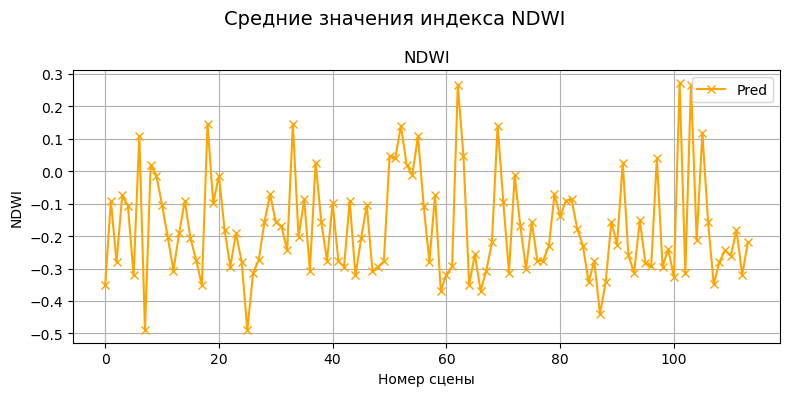

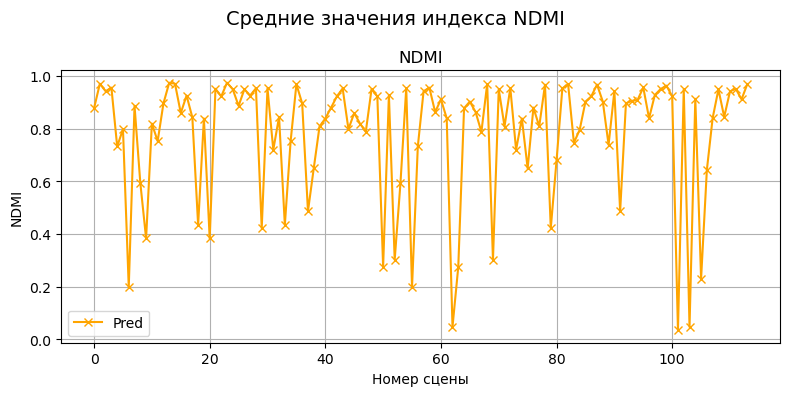

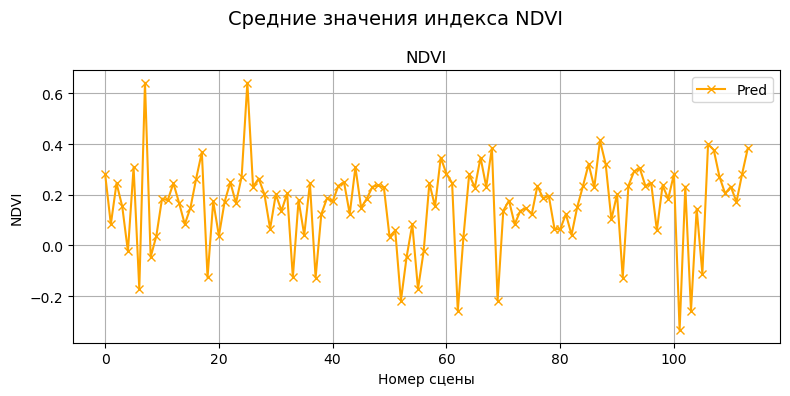

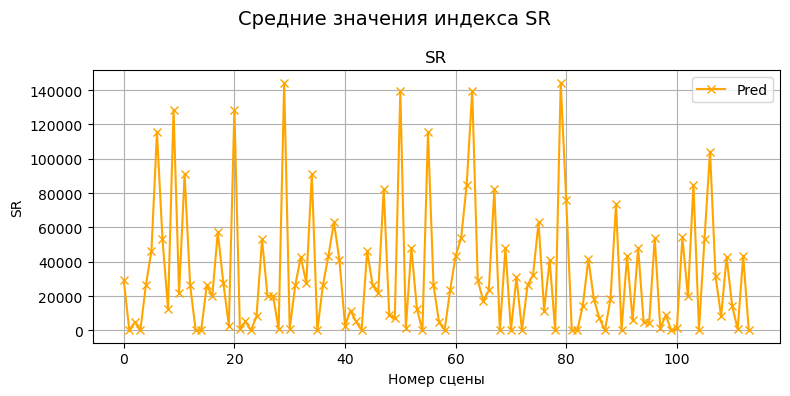

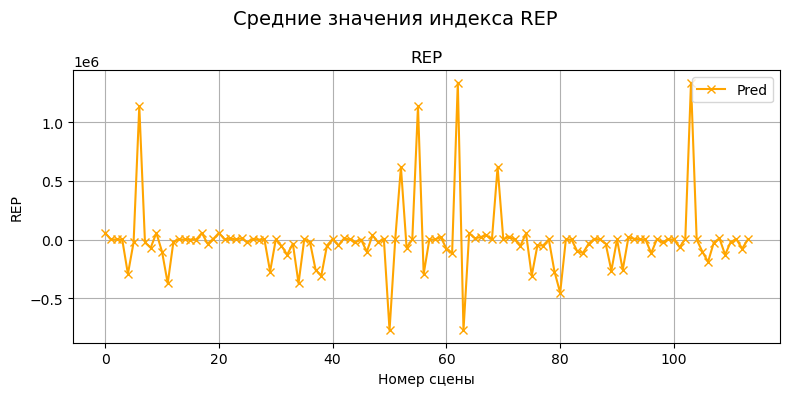

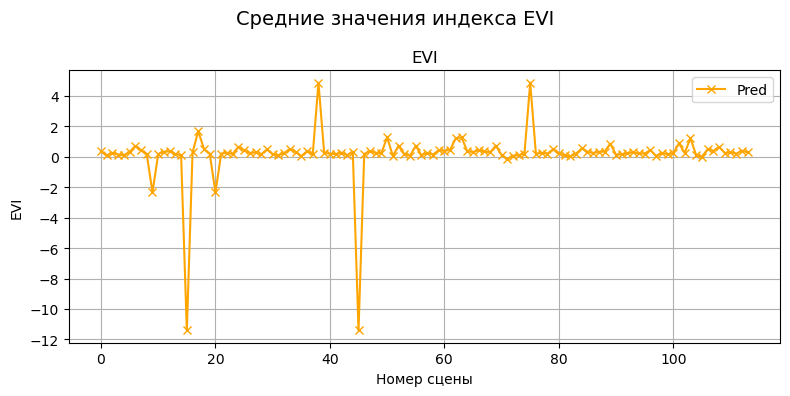

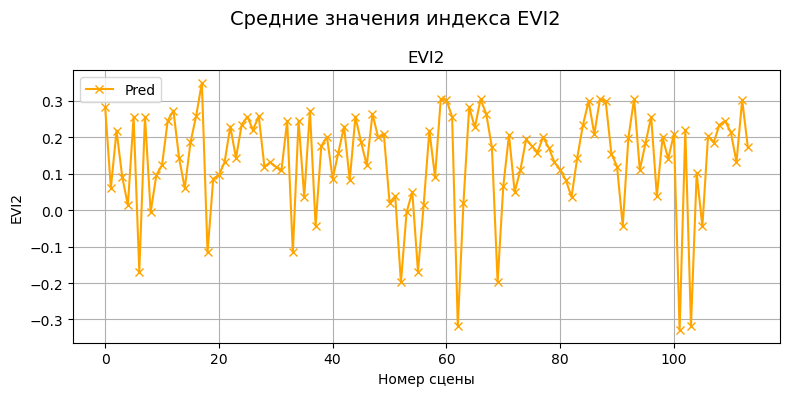

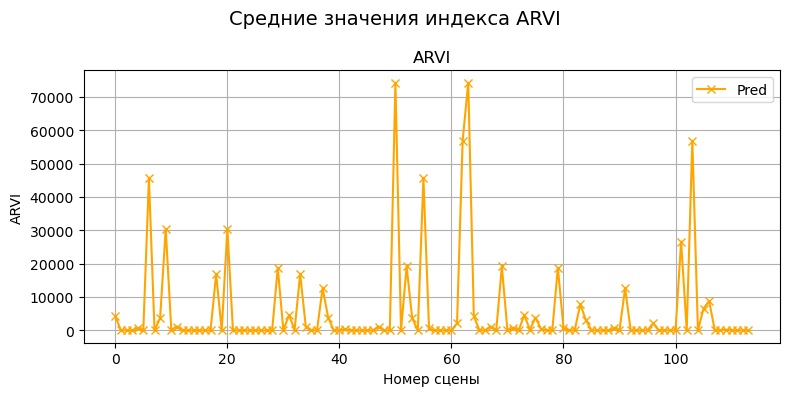

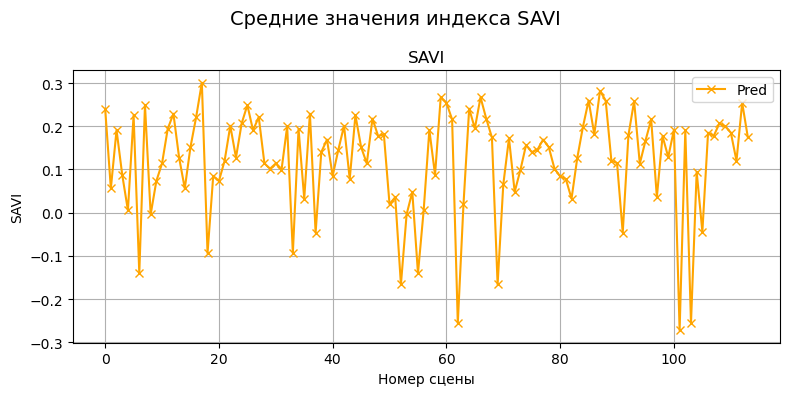

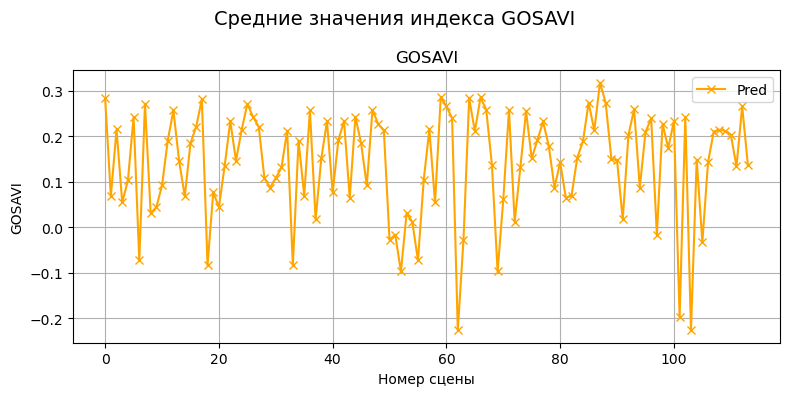

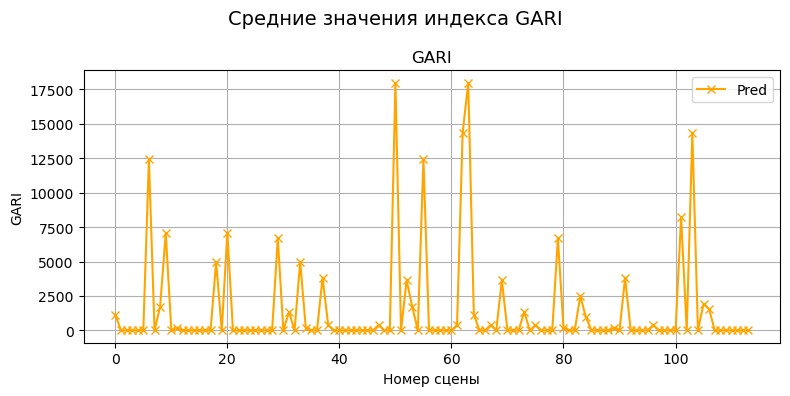

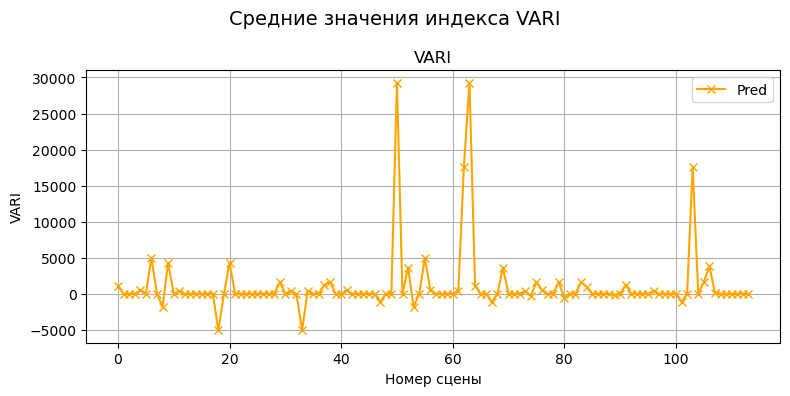

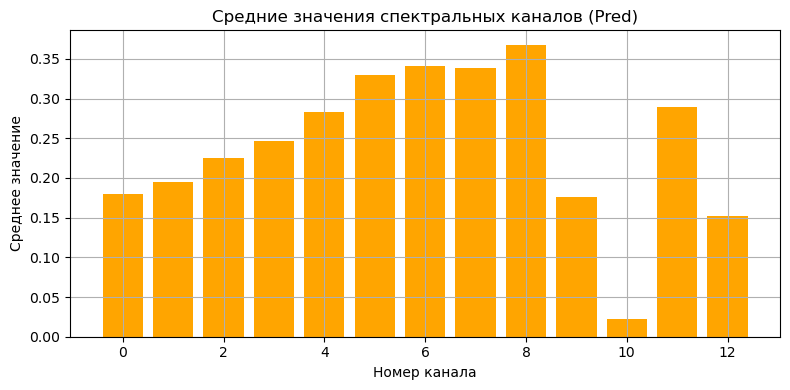


–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –∫–∞–Ω–∞–ª–æ–≤:
–ö–∞–Ω–∞–ª 0: Pred=0.1797
–ö–∞–Ω–∞–ª 1: Pred=0.1953
–ö–∞–Ω–∞–ª 2: Pred=0.2249
–ö–∞–Ω–∞–ª 3: Pred=0.2467
–ö–∞–Ω–∞–ª 4: Pred=0.2834
–ö–∞–Ω–∞–ª 5: Pred=0.3299
–ö–∞–Ω–∞–ª 6: Pred=0.3404
–ö–∞–Ω–∞–ª 7: Pred=0.3384
–ö–∞–Ω–∞–ª 8: Pred=0.3675
–ö–∞–Ω–∞–ª 9: Pred=0.1763
–ö–∞–Ω–∞–ª 10: Pred=0.0226
–ö–∞–Ω–∞–ª 11: Pred=0.2890
–ö–∞–Ω–∞–ª 12: Pred=0.1520


In [17]:
import matplotlib.pyplot as plt

mean_indices_by_scene = {idx: {"Pred": []} for idx in indices}

for dct in index_means_list:
    for idx_name in indices:
        mean_indices_by_scene[idx_name]["Pred"].append(dct[idx_name])

print("\n–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –∏–Ω–¥–µ–∫—Å–æ–≤ (Pred):")
for idx_name in indices:
    pr_arr = mean_indices_by_scene[idx_name]["Pred"]
    if len(pr_arr) > 0:
        print(f"{idx_name}: Pred={np.mean(pr_arr):.4f}")
    else:
        print(f"{idx_name}: –Ω–µ—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è Pred")

def plot_indices_in_row(mean_indices_by_scene, indices):
    for idx_name in indices:
        pr_vals = mean_indices_by_scene[idx_name]["Pred"]
        n_scenes = len(pr_vals)
        if n_scenes == 0:
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(pr_vals, marker='x', color='orange', label="Pred")
        ax.set_title(f"{idx_name}")
        ax.set_xlabel("–ù–æ–º–µ—Ä —Å—Ü–µ–Ω—ã")
        ax.set_ylabel(f"{idx_name}")
        ax.grid(True)
        ax.legend()
        plt.suptitle(f"–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –∏–Ω–¥–µ–∫—Å–∞ {idx_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_indices_in_row(mean_indices_by_scene, indices)

channel_means_pred = np.mean(channel_means_pred_list, axis=0) if channel_means_pred_list else None

if channel_means_pred is not None:
    x = np.arange(len(channel_means_pred))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x, channel_means_pred, color='orange', label="Pred")
    ax.set_title("–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã—Ö –∫–∞–Ω–∞–ª–æ–≤ (Pred)")
    ax.set_xlabel("–ù–æ–º–µ—Ä –∫–∞–Ω–∞–ª–∞")
    ax.set_ylabel("–°—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n–°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –∫–∞–Ω–∞–ª–æ–≤:")
    for i in range(len(channel_means_pred)):
        print(f"–ö–∞–Ω–∞–ª {i}: Pred={channel_means_pred[i]:.4f}")

def plot_histogram(data_list, channel_idx, label):
    all_vals = []
    for data in data_list:
        ch_data = data[channel_idx].numpy().flatten()
        all_vals.append(ch_data)
    if not all_vals:
        return
    all_vals = np.concatenate(all_vals)
    plt.figure(figsize=(10, 5))
    plt.hist(all_vals, bins=100, alpha=0.7, label=label)
    plt.title(f"–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –∫–∞–Ω–∞–ª–∞ {channel_idx} ({label})")
    plt.xlabel("–ó–Ω–∞—á–µ–Ω–∏–µ")
    plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∏–∫—Å–µ–ª–µ–π")
    plt.legend()
    plt.show()
    print(f"–ö–∞–Ω–∞–ª {channel_idx} ({label}): min={all_vals.min():.4f}, max={all_vals.max():.4f}")

#plot_histogram(pred_data_list, channel_idx=4, label="Pred")